# ECSE415 - Intro to Computer Vision
## Assignment 2
### Alexander Harris - 260688155

## Image Stitching
## 1. Coding Questions:

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Import images
hill1 = cv2.imread('./stitching_images/1Hill.JPG')
hill1_cpy = hill1.copy()
hill2 = cv2.imread('./stitching_images/2Hill.JPG')
hill2_cpy = hill2.copy()
hill3 = cv2.imread('./stitching_images/3Hill.JPG')
hill3_cpy = hill3.copy()

# Image dimensions
h1, w1, _ = hill1.shape
h2, w2, _ = hill2.shape
h3, w3, _ = hill3.shape

#### Helper Methods:

In [2]:
def PyramidBlending(imgA, imgB, depth=5):
    """
    Pyramid blending
    :param imgA: Left image
    :param imgB: Right image
    :param depth: Depth of pyramid
    :return: Stitched image
    """
    hA, wA, _ = imgA.shape
    
    # Generate Gaussian pyramids for A and B
    GA, GB = imgA.copy(), imgB.copy()
    gpA, gpB = [GA], [GB]
    for _ in range(depth):
        GA = cv2.pyrDown(GA)
        gpA.append(GA)
        GB = cv2.pyrDown(GB)
        gpB.append(GB)
    
    # Generate Laplacian pyramids for A and B
    lpA, lpB = [gpA[depth-1]], [gpB[depth-1]]
    for i in range(depth-1, 0, -1):
        hA, wA, _ = gpA[i-1].shape
        lp = cv2.subtract(gpA[i-1], cv2.pyrUp(gpA[i], dstsize=(wA, hA)), cv2.CV_32F)
        lpA.append(lp)

        hB, wB, _ = gpB[i-1].shape
        lp = cv2.subtract(gpB[i-1], cv2.pyrUp(gpB[i], dstsize=(wB, hB)), cv2.CV_32F)
        lpB.append(lp)
        
    # Add image halves together
    LP = []
    for lA, lB in zip(lpA, lpB):
        lp = np.hstack((lA, lB))
        LP.append(lp)

    rs = LP[0]
    for i in range(1, depth):
        rs = cv2.pyrUp(rs)
        rs = cv2.add(rs, LP[i])
    
    return rs.astype(np.uint8)

In [3]:
def Alpha(i_w, r_idx, ramp_size=50, start=0, end=1):
    """
    Computes alpha blending for Linear Image blending
    :param i_w: Width of image
    :param r_idx: Center of ramp
    :param ramp_size: Width of ramp
    :param start: start of ramp
    :param end: end of ramp
    :return: alpha blend
    """
    alpha = np.zeros((i_w)).astype(np.float)
    step = (end - start) / (ramp_size - 1)
    
    idx = r_idx - ramp_size
    for i in range(ramp_size):
        alpha[idx] = start + step * i
        idx += 1
    alpha[idx:] = 1
    
    return alpha

### 1.1 Compute SIFT keypoints and descriptors for 1Hill and 2Hill

In [4]:
# Compute SIFT keypoints and descriptors
sift = cv2.xfeatures2d.SIFT_create()
hill1_kp, hill1_des = sift.detectAndCompute(cv2.cvtColor(hill1, cv2.COLOR_BGR2RGB), None)
hill2_kp, hill2_des = sift.detectAndCompute(cv2.cvtColor(hill2, cv2.COLOR_BGR2RGB), None)

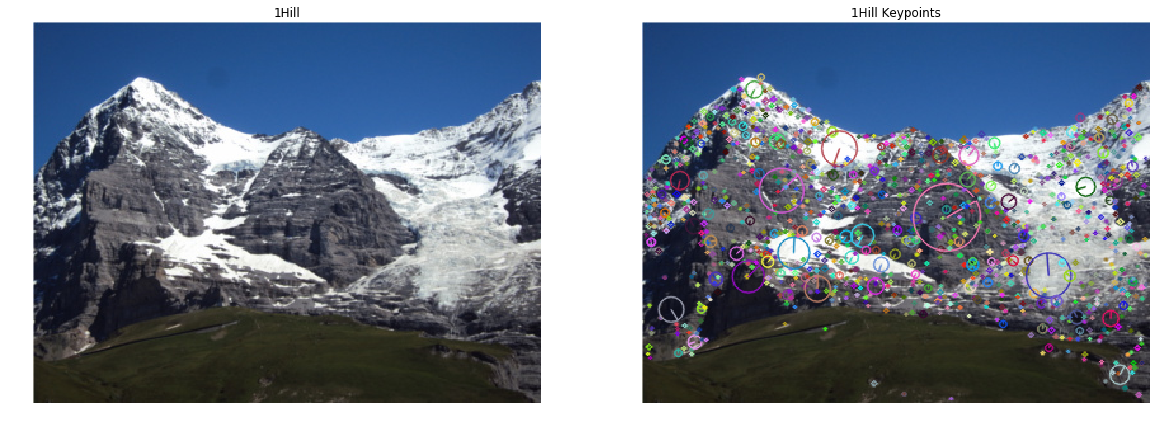

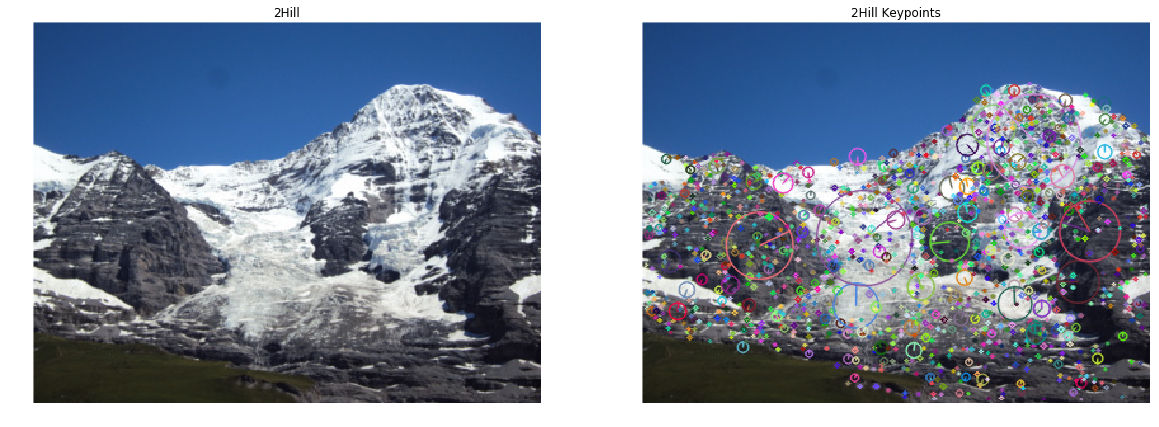

In [5]:
# Draw keypoints
cv2.drawKeypoints(hill1, hill1_kp, hill1_cpy, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(hill2, hill2_kp, hill2_cpy, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display
plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(cv2.cvtColor(hill1, cv2.COLOR_BGR2RGB))
plt.title('1Hill'), plt.axis('off')
plt.subplot(122), plt.imshow(cv2.cvtColor(hill1_cpy, cv2.COLOR_BGR2RGB))
plt.title('1Hill Keypoints'), plt.axis('off')
plt.show()

plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(cv2.cvtColor(hill2, cv2.COLOR_BGR2RGB))
plt.title('2Hill'), plt.axis('off')
plt.subplot(122), plt.imshow(cv2.cvtColor(hill2_cpy, cv2.COLOR_BGR2RGB))
plt.title('2Hill Keypoints'), plt.axis('off')
plt.show()

### 1.2 Find matching keypoints and display 20 best pairs

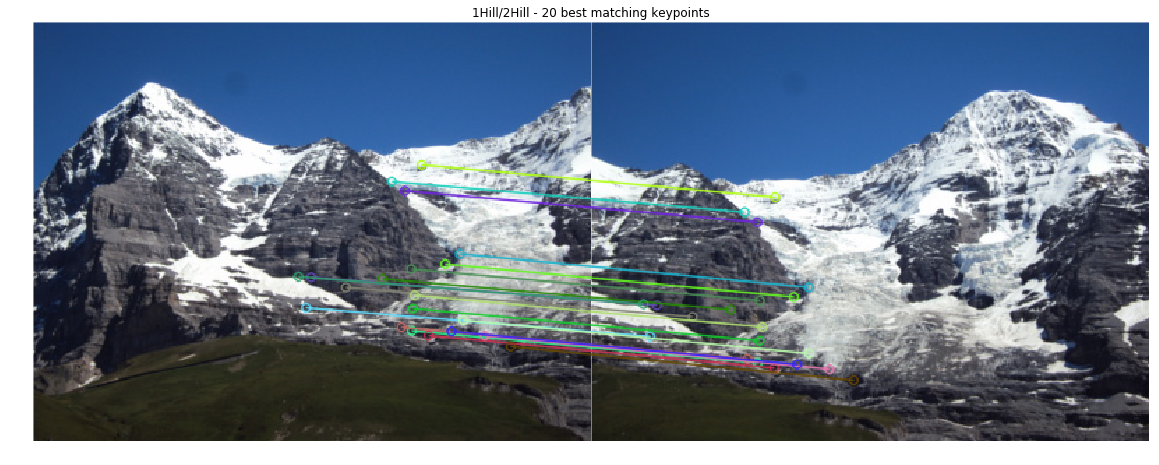

In [6]:
# Find matching keypoints
bf = cv2.BFMatcher()
matches = bf.match(hill1_des, hill2_des)
matches.sort(key=lambda x:x.distance)

# Display matches
match_img = cv2.drawMatches(hill1, hill1_kp, hill2, hill2_kp, matches[:20], hill1, flags=2)

plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
plt.title('1Hill/2Hill - 20 best matching keypoints'), plt.axis('off')
plt.show()

### 1.3 Find homography using RANSAC method and apply transformation to 1Hill

In [7]:
# Generate points for homography
good_matches = []
for match in matches:
    good_matches.append((match.trainIdx, match.queryIdx))
    
points_hill1 = np.float32([hill1_kp[i].pt for (_, i) in good_matches])
points_hill2 = np.float32([hill2_kp[i].pt for (i, _) in good_matches])

for point in points_hill2:
    point[0] += w2

# Find homography using RANSAC
hom, _ = cv2.findHomography(points_hill1, points_hill2, cv2.RANSAC, 10)

# Apply transformation to 1Hill
hill1_warped = cv2.warpPerspective(hill1, hom, (w1 + w2, h2))

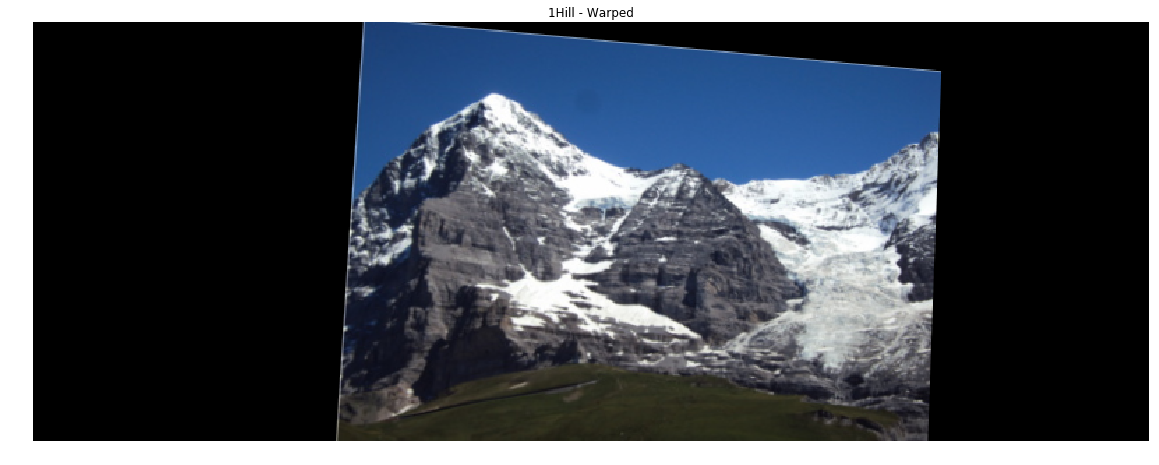

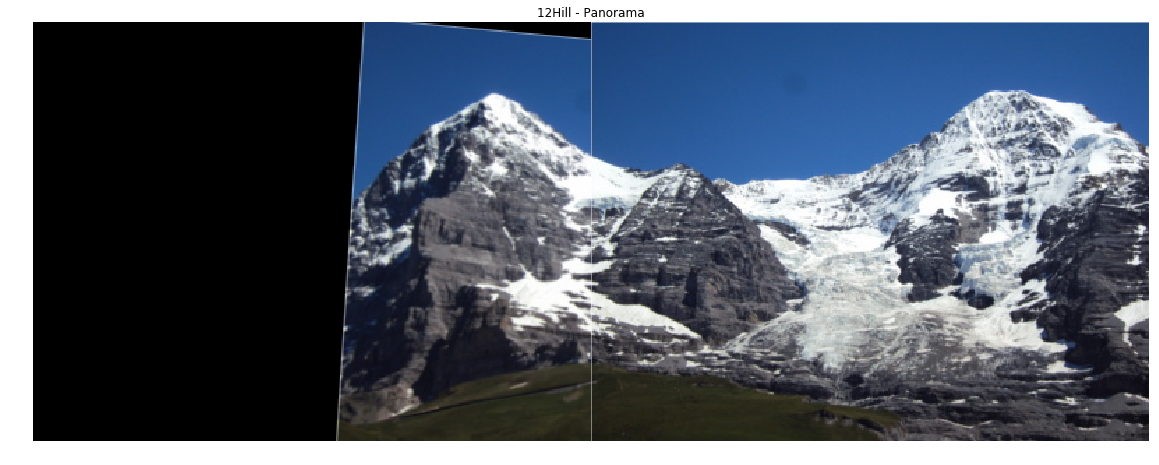

In [8]:
# Display
panorama = hill1_warped.copy()
panorama[:, w2:, :] = hill2

plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(hill1_warped, cv2.COLOR_BGR2RGB))
plt.title('1Hill - Warped'), plt.axis('off')
plt.show()

plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.title('12Hill - Panorama'), plt.axis('off')
plt.show()

### 1.4 Stitch transformed 1Hill and 2Hill together using pyramid blending

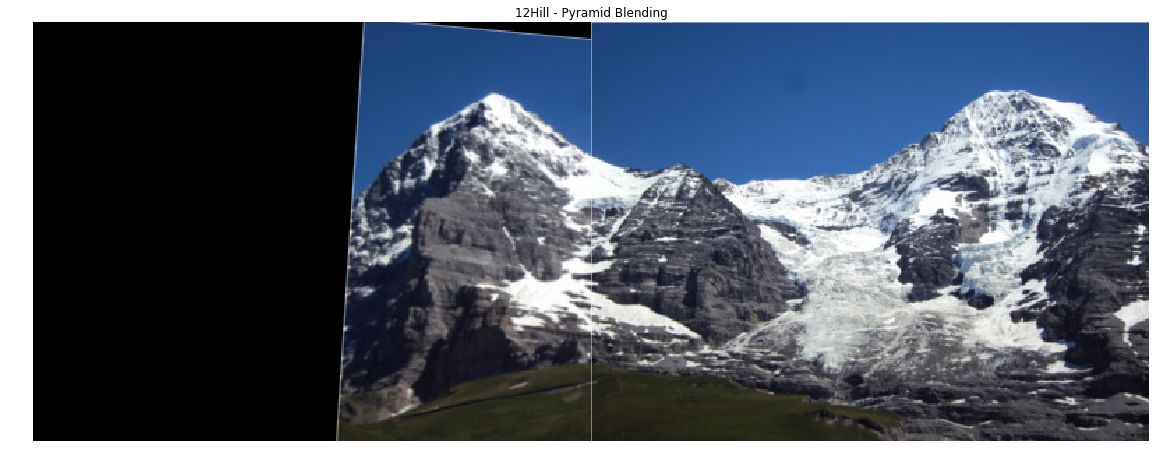

In [9]:
# Stitch images using pyramid blending
hill12 = PyramidBlending(hill1_warped[:, :w1], hill2, 1)

plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(hill12, cv2.COLOR_BGR2RGB))
plt.title('12Hill - Pyramid Blending'), plt.axis('off')
plt.show()

### 1.5 Compute SURF keypoints and descriptors for 12Hill and 3Hill

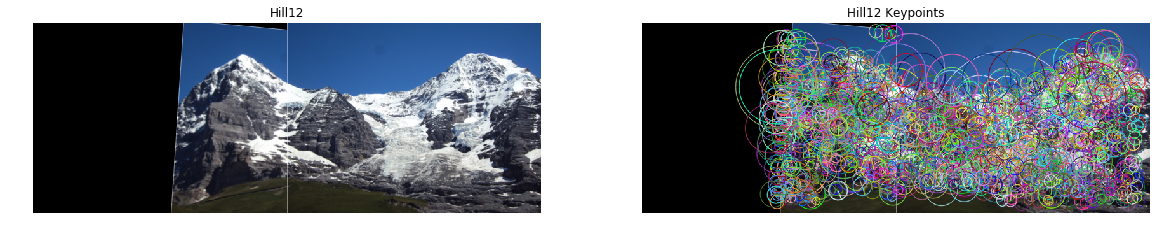

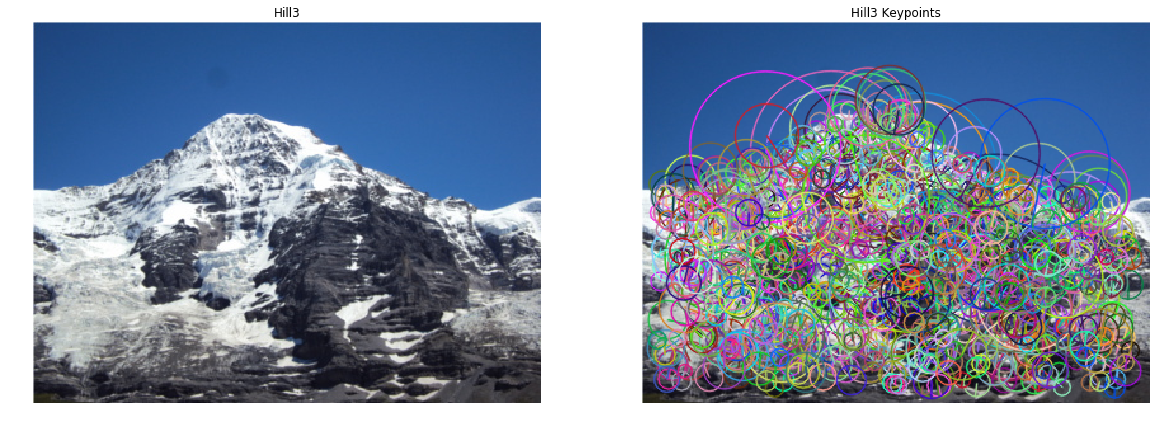

In [10]:
h12, w12, _ = hill12.shape
hill12_cpy = hill12.copy()

surf = cv2.xfeatures2d.SURF_create()

# Compute SURF features for hill12 and hill3
hill12_kp, hill12_des = surf.detectAndCompute(cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY), None)
hill3_kp, hill3_des = surf.detectAndCompute(cv2.cvtColor(hill3, cv2.COLOR_BGR2GRAY), None)

# Draw keypoints
cv2.drawKeypoints(hill12, hill12_kp, hill12_cpy, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(hill3, hill3_kp, hill3_cpy, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display
plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(cv2.cvtColor(hill12, cv2.COLOR_BGR2RGB))
plt.title('Hill12'), plt.axis('off')
plt.subplot(122), plt.imshow(cv2.cvtColor(hill12_cpy, cv2.COLOR_BGR2RGB))
plt.title('Hill12 Keypoints'), plt.axis('off')
plt.show()

plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(cv2.cvtColor(hill3, cv2.COLOR_BGR2RGB))
plt.title('Hill3'), plt.axis('off')
plt.subplot(122), plt.imshow(cv2.cvtColor(hill3_cpy, cv2.COLOR_BGR2RGB))
plt.title('Hill3 Keypoints'), plt.axis('off')
plt.show()

### 1.6 Find matching keypoints and display 20 best pairs

In [11]:
# Find matching keypoint and display
bf = cv2.BFMatcher()
matches_12_3 = bf.match(hill12_des, hill3_des)
matches_12_3.sort(key=lambda x:x.distance)

match_img123 = cv2.drawMatches(hill12, hill12_kp, hill3, hill3_kp, matches_12_3[:20], hill12, flags=2)

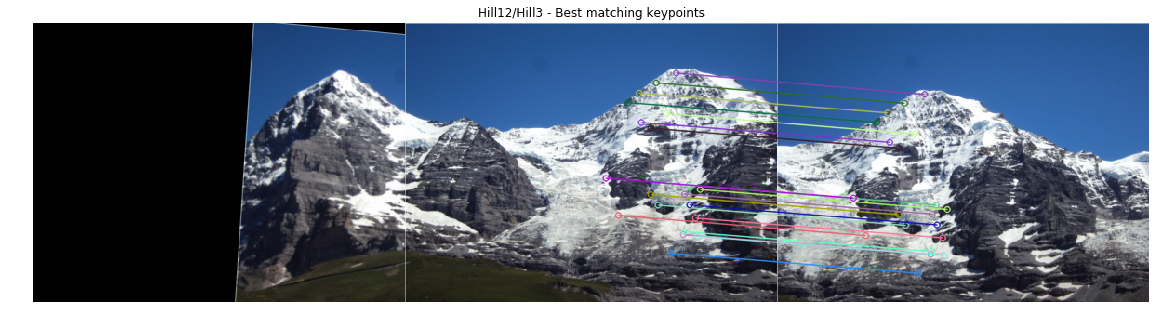

In [12]:
plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(match_img123, cv2.COLOR_BGR2RGB))
plt.title('Hill12/Hill3 - Best matching keypoints'), plt.axis('off')
plt.show()

### 1.7 Find homography using RANSAC and apply transformation to 3Hill

In [13]:
# Generate points for homography
good_match123 = []
for m in matches_12_3:
    good_match123.append((m.trainIdx, m.queryIdx))
    
points_12 = np.float32([hill12_kp[i].pt for (_, i) in good_match123])
points_3 = np.float32([hill3_kp[i].pt for (i, _) in good_match123])

# Compute homography
hom3, _ = cv2.findHomography(points_3, points_12, cv2.RANSAC, 10)

# Apply transformation
hill3_warped = cv2.warpPerspective(hill3, hom3, (w12 + w3, h12))

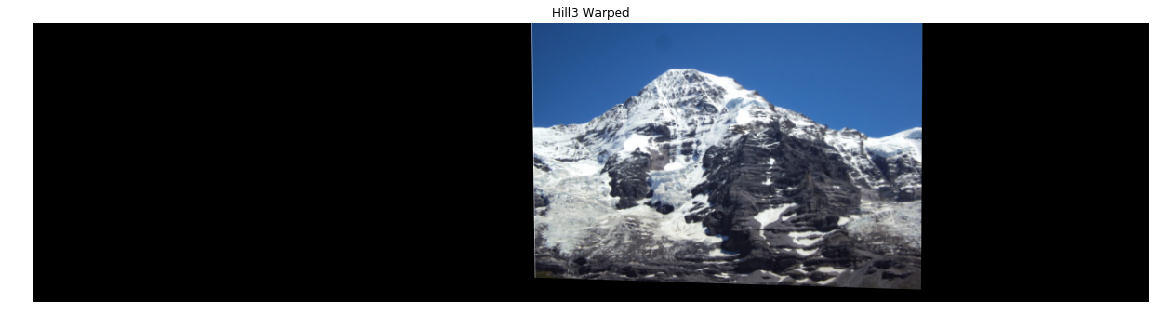

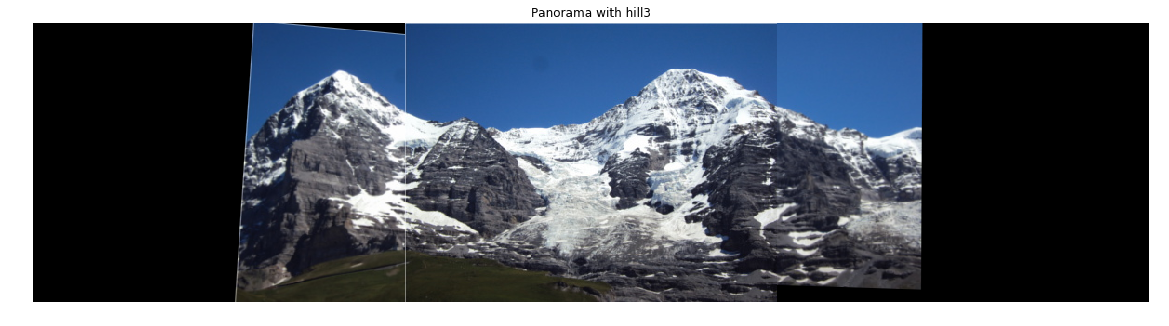

In [14]:
# Display
panorama123 = hill3_warped.copy()
panorama123[:, :w12, :] = hill12

plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(hill3_warped, cv2.COLOR_BGR2RGB))
plt.title('Hill3 Warped'), plt.axis('off')
plt.show()

plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(panorama123, cv2.COLOR_BGR2RGB))
plt.title('Panorama with hill3'), plt.axis('off')
plt.show()

### 1.8 Stitch images together using linear blending

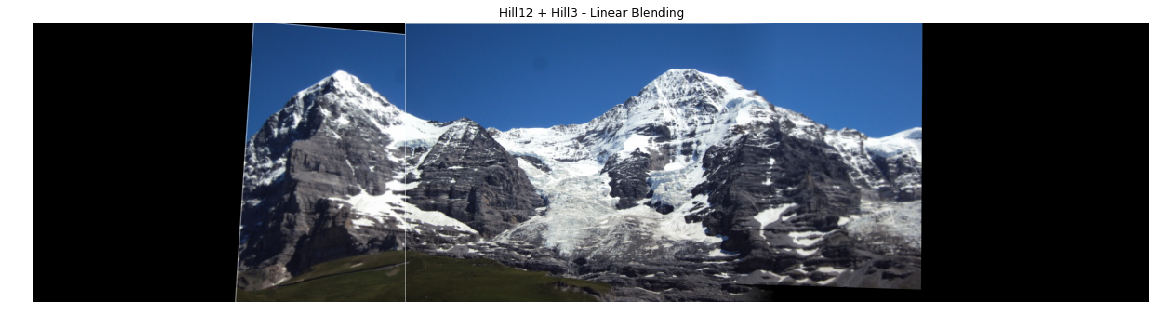

In [15]:
# Stitch images together using Linear Blending
imgA = np.uint8(np.zeros((h12, w12 + w3, 3)))
imgA[:, :w12, :] = hill12
alpha = Alpha(imgA.shape[1], w12, ramp_size=50)

blend = np.uint8((1 - alpha.reshape(1, -1, 1))*imgA + alpha.reshape(1, -1, 1)*hill3_warped)

plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(blend, cv2.COLOR_BGR2RGB))
plt.title('Hill12 + Hill3 - Linear Blending'), plt.axis('off')
plt.show()

## 2. Reasoning Questions

### 2.1 Differences between SIFT and SURF
SURF is essentially a faster version of SIFT. While SIFT uses DoG to approximate LoG when detecting corners, SURF approximates this even further and uses a box filter. Also, SURF will use the Hessian matrix to compute both scale and location instead of using separate operations. On average, this makes SURF around 3 times faster than SIFT, but with some drawbacks. Namely, SURF will have more difficulty handling changes in perspective as well as illumination when compared to SIFT.

In [16]:
print("1Hill: %d" % len(hill1_kp))
print("2Hill: %d" % len(hill2_kp))
print("3Hill: %d" % len(hill3_kp))

1Hill: 1217
2Hill: 1494
3Hill: 879


We can see this in effect above, as the keypoints of 1Hill and 2Hill computed with SIFT are much higher than of 3Hill, which was computed using SURF.

### 2.2 Pros and cons of pyramid and linear blending
Pyramid Blending:  
Pros:
- Less prone to ghosting
- Better for images with different frequencies
Cons:
- Longer runtime
- More complex implementation

Linear Blending:  
Pros:
- Simple implementation
- Shorter runtime
Cons:
- More prone to ghosting
- Not good for images with much different frequencies

We should choose Pyramid blending over Linear when runtime is less of a factor and we desire minimal ghosting in the final image.

### 2.3 Using a random subset of pairs of matching keypoints for finding homography
This may cause the perspective warping to be innacurate and lead to a poorly stitched image.

### 2.4 Relationsjip between number of pairs used for finding homography and accurace of homography
A higher number of pairs can actually be detrimental to the final result if they end up mostly being bad matches, as this is would affect the accuracy of the homography. Accuracy or "strength" of the individual matches is generally more important than the overall number of them.